# Dataset importation
At first, we import the dataset in csv format and perform an essential exploration of its features.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [409]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold

In [2]:
data = pd.read_csv('CrowdstormingDataJuly1st.csv')
data.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


## Splitting in testing and train

Since some labels are missing we consider for the training dataset the players with both ratings.
Note that there are no players with a single rating missing.

In [3]:
final_test=data[data.rater2.isnull() & data.rater1.isnull()]
final_train=data[data.rater2.notnull() & data.rater1.notnull()]

In [4]:
final_train.shape

(124621, 28)

In [5]:
final_test.shape

(21407, 28)

In [6]:
data.shape

(146028, 28)

# Data analysis

In [7]:
def preprocess(database):
    train=final_train.copy()
    del train['photoID']
    return train

In [8]:
train=preprocess(final_train)

In [9]:
train

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,...,0.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
6,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,...,0.25,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
7,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,...,1.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
8,anders-lindegaard,Anders Lindegaard,Manchester United,England,13.04.1984,193.0,80.0,Goalkeeper,1,0,...,0.25,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
9,andreas-beck,Andreas Beck,1899 Hoffenheim,Germany,13.03.1987,180.0,70.0,Right Fullback,1,1,...,0.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
10,antonio-rukavina,Antonio Rukavina,Real Valladolid,Spain,26.01.1984,177.0,74.0,Right Fullback,2,2,...,0.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
11,ashkan-dejagah,Ashkan Dejagah,Fulham FC,England,05.07.1986,181.0,74.0,Left Winger,1,1,...,0.50,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
12,benedikt-hoewedes,Benedikt Höwedes,FC Schalke 04,Germany,29.02.1988,187.0,80.0,Center Back,1,1,...,0.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752


In [401]:
max(train.nExp)

2029548.0

# Random forest with only trivial information
No referee information used


### Preprocessing of dataset

In [426]:
train_trivial=train.groupby('playerShort').first()

In [427]:
train_trivial.birthday=train_trivial.birthday.apply(lambda x: int(x.split('.')[2]))

In [428]:
y_trivial=(train_trivial['rater1']+train_trivial['rater2'])/2

In [429]:
train_trivial=train_trivial[['leagueCountry','birthday','height','weight','position']]

In [430]:
train_trivial=train_trivial.fillna(train_trivial.median())

In [431]:
train_trivial.head(4)

,leagueCountry,birthday,height,weight,position
playerShort,,,,,
aaron-hughes,England,1979,182.0,71.0,Center Back
aaron-hunt,Germany,1986,183.0,73.0,Attacking Midfielder
aaron-lennon,England,1987,165.0,63.0,Right Midfielder
aaron-ramsey,England,1990,178.0,76.0,Center Midfielder


In [435]:
train_trivial.position=train_trivial.position.fillna('nan')

In [436]:
train_trivial.leagueCountry=train_trivial.leagueCountry.fillna('nan')

In [437]:
len(train_trivial)

1585

### Categorizing data

In [439]:
a=pd.get_dummies(train_trivial[['position','leagueCountry']])

In [440]:
train_trivial=pd.concat([train_trivial,a],axis=1)

In [442]:
del train_trivial['leagueCountry']
del train_trivial['position']
train_trivial.head(4)

,birthday,height,weight,position_Attacking Midfielder,position_Center Back,position_Center Forward,position_Center Midfielder,position_Defensive Midfielder,position_Goalkeeper,position_Left Fullback,position_Left Midfielder,position_Left Winger,position_Right Fullback,position_Right Midfielder,position_Right Winger,position_nan,leagueCountry_England,leagueCountry_France,leagueCountry_Germany,leagueCountry_Spain
playerShort,,,,,,,,,,,,,,,,,,,,
aaron-hughes,1979,182.0,71.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
aaron-hunt,1986,183.0,73.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
aaron-lennon,1987,165.0,63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
aaron-ramsey,1990,178.0,76.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### Splitting in training and test database

In [443]:
X_train, X_test, y_train, y_test = train_test_split(train_trivial, y_trivial, test_size=0.4, random_state=4)

### Classification

In [444]:
def evaluate_random_forest_model(X_train,X_test,y_train,y_test,n_estimators=10,criterion='gini',
                                max_depth=None):
    rfc = RandomForestClassifier(n_estimators=n_estimators,criterion=criterion,
                                max_depth=max_depth)
    rfc.fit(X_train,np.asarray(y_train, dtype="|S6"))
    y_out=rfc.predict(X_test)
    y_out=np.asarray(y_out,float)
    return metrics.mean_squared_error(y_out,y_test.values)

### Overfitting
The first is the error with train and test split

The second is the error evaluated in the train database

In [445]:
evaluate_random_forest_model(X_train,X_test,y_train,y_test)

0.11979988170347003

In [446]:
evaluate_random_forest_model(X_train,X_train,y_train,y_train)

0.0059476866456361728

### Parameter variation to estimate overfitting

In [277]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)


In [256]:
error_train=[]
error_test=[]
for i in range(1,20):
    error_test.append(evaluate_random_forest_model(X_train,X_test,y_train,y_test,max_depth=i))
    error_train.append(evaluate_random_forest_model(X_train,X_train,y_train,y_train,max_depth=i))


max_depth

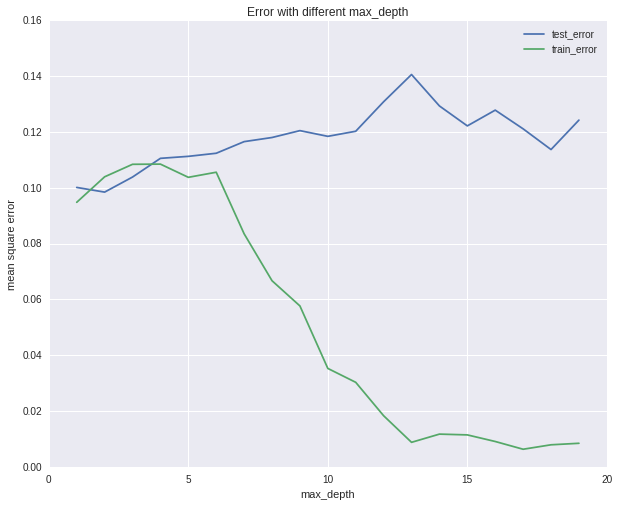

In [278]:
plt.plot(range(1,20),error_test)
plt.plot(range(1,20),error_train)
plt.legend(['test_error','train_error'])
plt.title('Error with different max_depth')
plt.xlabel('max_depth')
plt.ylabel('mean square error')

n_estimators

In [282]:
error_train=[]
error_test=[]
for i in range(1,40):
    error_test.append(evaluate_random_forest_model(X_train,X_test,y_train,y_test,n_estimators=i))
    error_train.append(evaluate_random_forest_model(X_train,X_train,y_train,y_train,n_estimators=i))


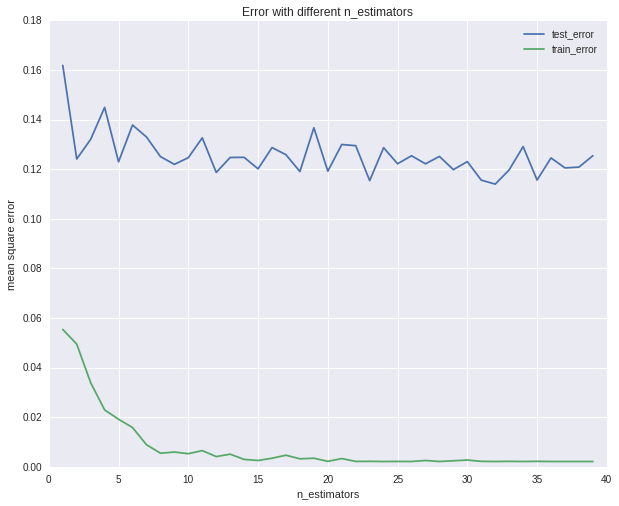

In [284]:
plt.plot(range(1,40),error_test)
plt.plot(range(1,40),error_train)
plt.legend(['test_error','train_error'])
plt.title('Error with different n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('mean square error')

criterion

In [303]:
error_train=[]
error_test=[]

error_test.append(evaluate_random_forest_model(X_train,X_test,y_train,y_test,criterion='gini'))
error_train.append(evaluate_random_forest_model(X_train,X_train,y_train,y_train,criterion='gini'))

error_test.append(evaluate_random_forest_model(X_train,X_test,y_train,y_test,criterion='entropy'))
error_train.append(evaluate_random_forest_model(X_train,X_train,y_train,y_train,criterion='entropy'))

In [304]:
error_train

[0.005208333333333333, 0.0053562039957939008]

In [305]:
error_test

[0.1245563880126183, 0.12906644321766561]

### Cross validation

In [385]:
kf = KFold(train_trivial.shape[0], n_folds=30, shuffle=True)

In [386]:
def cross_val(database,output,n_estimators=10,criterion='gini',
                                max_depth=None):
    error_train=[]
    error_test=[]
    for iteration, data in enumerate(kf, start=1):
        X_train=database.iloc[data[0]]
        X_test=database.iloc[data[1]]
        y_train=output.iloc[data[0]]
        y_test=output.iloc[data[1]]

        error_test.append(evaluate_random_forest_model(X_train,X_test,y_train,y_test,
                                                       n_estimators=n_estimators,criterion=criterion,
                                                       max_depth=max_depth))
        error_train.append(evaluate_random_forest_model(X_train,X_train,y_train,y_train,
                                                        n_estimators=n_estimators,criterion=criterion,
                                                       max_depth=max_depth))
    return np.mean(error_train),np.mean(error_test)


max_depth

In [387]:
error_train=[]
error_test=[]
for i in range(1,40):
    error_train_,error_test_=cross_val(train_trivial,y_trivial,max_depth=i)
    error_train.append(error_train_)
    error_test.append(error_test_)


[ 0.4  0.4  0.   0.2  0. ]
[ 0.2  0.4  0.4  0.   0. ]
[ 0.4  0.5  0.   0.   0.1]
[ 0.5  0.2  0.3  0.   0. ]
[ 0.6  0.2  0.   0.2  0. ]
[ 0.4  0.3  0.1  0.1  0.1]
[ 0.4  0.3  0.2  0.1  0. ]
[ 0.   0.6  0.3  0.1  0. ]
[ 0.4  0.2  0.4  0.   0. ]
[ 0.2  0.3  0.4  0.   0.1]
[ 0.5  0.3  0.1  0.1  0. ]
[ 0.3  0.5  0.1  0.1  0. ]
[ 0.5  0.2  0.2  0.1  0. ]
[ 0.2  0.1  0.5  0.1  0.1]
[ 0.3  0.3  0.1  0.3  0. ]
[ 0.3  0.5  0.1  0.   0.1]
[ 0.4  0.4  0.1  0.   0.1]
[ 0.4  0.1  0.4  0.   0.1]
[ 0.3  0.1  0.4  0.   0.2]
[ 0.5  0.2  0.2  0.   0.1]
[ 0.3  0.2  0.4  0.1  0. ]
[ 0.7  0.2  0.1  0.   0. ]
[ 0.5  0.1  0.3  0.1  0. ]
[ 0.2  0.5  0.2  0.   0.1]
[ 0.2  0.3  0.4  0.   0.1]
[ 0.5  0.2  0.3  0.   0. ]
[ 0.6  0.2  0.   0.   0.2]
[ 0.4  0.1  0.4  0.   0.1]
[ 0.5  0.1  0.3  0.   0.1]
[ 0.2  0.2  0.6  0.   0. ]
[ 0.2  0.5  0.2  0.   0.1]
[ 0.3  0.4  0.2  0.   0.1]
[ 0.4  0.1  0.4  0.   0.1]
[ 0.2  0.2  0.1  0.2  0.3]
[ 0.4  0.2  0.3  0.   0.1]
[ 0.3  0.2  0.2  0.1  0.2]
[ 0.5  0.1  0.3  0.   0.1]
[

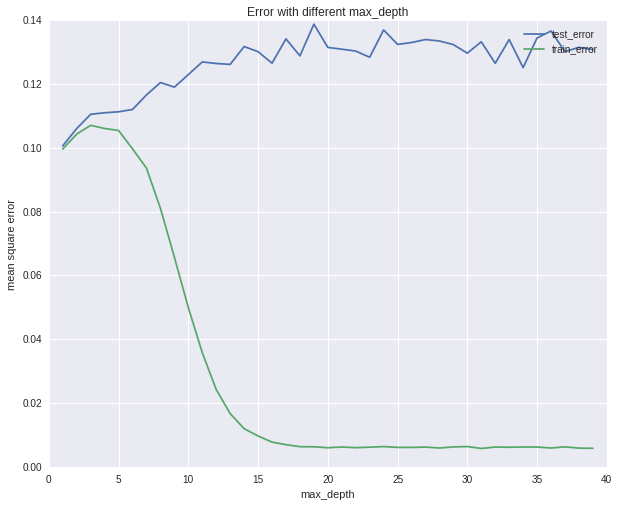

In [389]:
plt.plot(range(1,40),error_test)
plt.plot(range(1,40),error_train)
plt.legend(['test_error','train_error'])
plt.title('Error with different max_depth')
plt.xlabel('max_depth')
plt.ylabel('mean square error')

n_estimators

In [390]:
error_train=[]
error_test=[]
for i in range(1,40):
    error_train_,error_test_=cross_val(train_trivial,y_trivial,n_estimators=i)
    error_train.append(error_train_)
    error_test.append(error_test_)


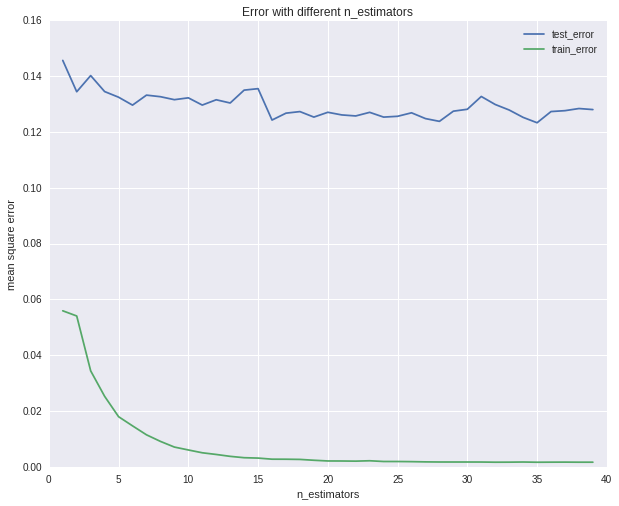

In [391]:
plt.plot(range(1,40),error_test)
plt.plot(range(1,40),error_train)
plt.legend(['test_error','train_error'])
plt.title('Error with different n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('mean square error')

criterion

In [395]:
error_train=[]
error_test=[]

error_train_,error_test_=cross_val(train_trivial,y_trivial,criterion='gini')

error_train.append(error_train_)
error_test.append(error_test_)

error_train_,error_test_=cross_val(train_trivial,y_trivial,criterion='entropy')

error_train.append(error_train_)
error_test.append(error_test_)

In [396]:
error_train

[0.0058454681834284559, 0.0061177514058993413]

In [397]:
error_test

[0.13110278332123851, 0.13261425828495407]